This notebook creates figures and plots from the paper. It requires the `ensembles.csv` file. If you only wish to reproduce plots and tables, you may find it in the repository.

If you want to draw your own plots based on your results, please run `templates_ensemble.py` with desired parameters and then proceed to the `ensembles_data_to_csv.ipynb` notebook prior to this one to parse and save your results as a `.csv` file.

# Imports and Config

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from itertools import chain

In [2]:
font_size = 24

%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({
        "font.family": "Times New Roman",
        "axes.labelsize": font_size,
        "font.size": font_size,
        "legend.fontsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
})

In [3]:
datasets = ["trec", "sst2", "dbpedia", "agnews"]

In [4]:
labels_mp = {
    "trec": dict(enumerate(["Description", "Entity", "Expression", "Human", "Location", "Number"])),
    "sst2": dict(enumerate(['negative', 'positive'])),
    "dbpedia": dict(enumerate(["Company", "Educational Institution", "Artist", "Athlete", "Office Holder",
                                     "Mean Of Transportation", "Building", "Natural Place", "Village", "Animal",
                                     "Plant", "Album", "Film", "Written Work"])),
    "agnews": dict(enumerate(["World", "Sports", "Business", "Technology"])),
}

In [5]:
# save val targets to avoid loading the whole dataset next time

from data import load_split_dataset

for dataset in datasets:
    _, val, _ = load_split_dataset(dataset)
    with open(f"val_{dataset}.txt", "w") as f:
        print("\n".join(val), file=f)

In [6]:
# load pre-saved val targets

val = {}
for dataset in datasets:
    with open(f"val_{dataset}.txt", "r") as f:
        val[dataset] = np.array([x for x in f.read().split("\n") if x])

In [7]:
ensembles_csv_path = "ensembles.csv"  # your path to csv with ensembles results

ensembles_df = pd.read_csv(ensembles_csv_path)
ensembles_df.head()

,dataset,model,pred_method,size,mean,std
0,trec,llama-7b,calibrate_True,1,0.191333,0.042153
1,trec,llama-7b,calibrate_True,2,0.432667,0.105708
2,trec,llama-7b,calibrate_True,3,0.460000,0.097379
3,trec,llama-7b,calibrate_True,4,0.515333,0.049026
4,trec,llama-7b,calibrate_True,5,0.533333,0.044582


In [8]:
path_to_runs = "general_runs.csv"  # your path to csv with all runs

general_runs = pd.read_csv(path_to_runs)
general_runs.head()

,seed,model,dataset,n_shots,precision,batch_size,template_seed,prediction_method,selection_method,scores
0,59,llama-65b,dbpedia,4,fp16,16,13,direct_False,random,"[0.519, 0.562, 0.562, 0.559, 0.35, 0.534, 0.49..."
1,59,llama-2-70b-hf,dbpedia,4,fp16,16,13,direct_False,random,"[0.585, 0.637, 0.637, 0.624, 0.592, 0.576, 0.5..."
2,59,llama-65b,dbpedia,4,fp16,16,21,direct_False,random,"[0.564, 0.576, 0.244, 0.535, 0.396, 0.508, 0.0..."
3,59,llama-2-70b-hf,dbpedia,4,fp16,16,21,direct_False,random,"[0.561, 0.615, 0.478, 0.584, 0.568, 0.6, 0.367..."
4,59,llama-2-70b-hf,dbpedia,4,fp16,16,21,direct_False,implicitly_topic_models,"[0.503, 0.507, 0.354, 0.492, 0.449, 0.504, 0.4..."


# Drawing Figure 6

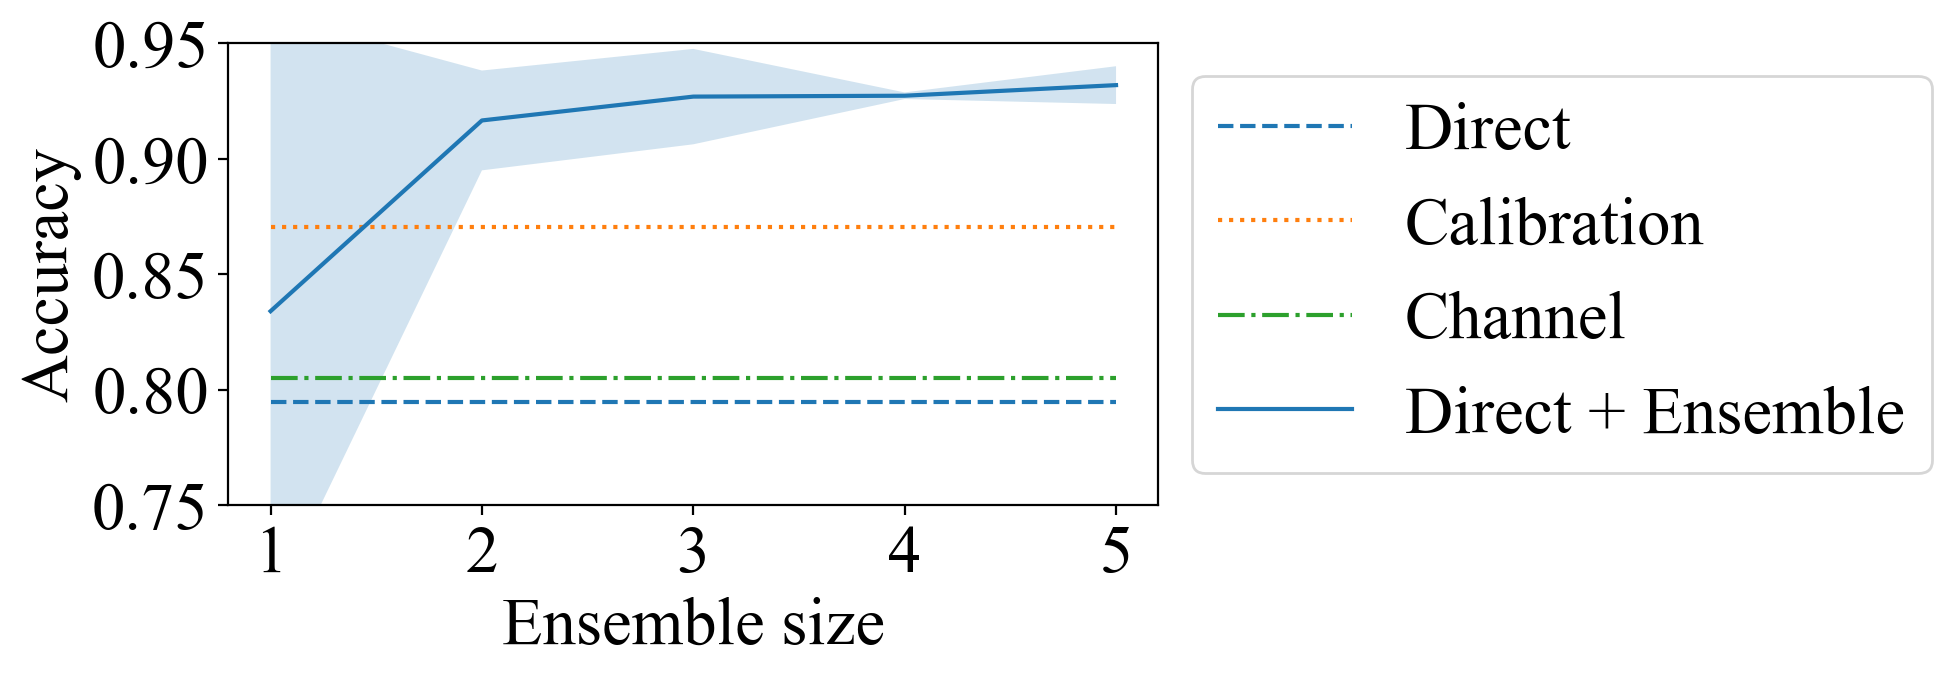

In [9]:
dataset = "sst2"
model = "falcon-40b"

sizes = [1, 2, 3, 4, 5]

fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(111)

labels = {"direct_False": "Direct", "calibrate_True": "Calibration", "channel_True": "Channel"}
linestyles = {"Direct": "dashed", "Calibration": "dotted", "Channel": "dashdot"}
colours = {"Direct": "C0", "Calibration": "C1", "Channel": "C2"}
#for pred_method, (mean, std) in mean_std[model].items():
#    ax.plot(sizes, [mean for i in range(1,6)], linestyle=linestyles[pred_method], c=colours[pred_method], label=pred_method)
for pred_method in ["direct_False", "calibrate_True", "channel_True"]:
    single = general_runs[
            (general_runs["dataset"] == dataset)
            & (general_runs["model"] == model)
            & (general_runs["prediction_method"] == pred_method)
            & (general_runs["selection_method"] == "random")
            & (general_runs["n_shots"] == 2)
            & (general_runs["template_seed"] == 59)
    ]
    single_scores = list(chain.from_iterable([eval(scores_list) for scores_list in single["scores"].values]))
    single_mean = np.mean(single_scores)
    pred_method_label = labels[pred_method]
    ax.plot(sizes, [single_mean for i in range(1,6)],
            linestyle=linestyles[pred_method_label],
            c=colours[pred_method_label],
            label=pred_method_label)


pred_method = "direct_False"

sub_df = ensembles_df[
    (ensembles_df["model"] == model)
    & (ensembles_df["dataset"] == dataset)
    & (ensembles_df["pred_method"] == pred_method)
]

size_to_mean_std = {}
for _, row in sub_df.iterrows():
    size_to_mean_std[row["size"]] = (row["mean"], row["std"])
size_to_mean_std = {size: value for size, value in sorted(size_to_mean_std.items(), key=lambda x: x[0])}

ax.plot(sizes,
         [mean for mean, _ in size_to_mean_std.values()], label="Direct + Ensemble",
        color="C0")
ax.fill_between(
    sizes,
    [mean - std for mean, std in size_to_mean_std.values()],
    [mean + std for mean, std in size_to_mean_std.values()],
    alpha=.2,
)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Ensemble size")
plt.ylabel("Accuracy")
plt.xticks([1, 2, 3, 4, 5])
plt.ylim(0.75, 0.95)
plt.yticks([0.75, 0.80, 0.85, 0.90, 0.95])
plt.savefig('ensemble.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

# Tables 5, 13, 14

In [10]:
path_to_runs = "general_runs.csv"  # your path to csv with all runs

general_runs = pd.read_csv(path_to_runs)
general_runs.head()

,seed,model,dataset,n_shots,precision,batch_size,template_seed,prediction_method,selection_method,scores
0,59,llama-65b,dbpedia,4,fp16,16,13,direct_False,random,"[0.519, 0.562, 0.562, 0.559, 0.35, 0.534, 0.49..."
1,59,llama-2-70b-hf,dbpedia,4,fp16,16,13,direct_False,random,"[0.585, 0.637, 0.637, 0.624, 0.592, 0.576, 0.5..."
2,59,llama-65b,dbpedia,4,fp16,16,21,direct_False,random,"[0.564, 0.576, 0.244, 0.535, 0.396, 0.508, 0.0..."
3,59,llama-2-70b-hf,dbpedia,4,fp16,16,21,direct_False,random,"[0.561, 0.615, 0.478, 0.584, 0.568, 0.6, 0.367..."
4,59,llama-2-70b-hf,dbpedia,4,fp16,16,21,direct_False,implicitly_topic_models,"[0.503, 0.507, 0.354, 0.492, 0.449, 0.504, 0.4..."


In [11]:
ensembles_df.head()

,dataset,model,pred_method,size,mean,std
0,trec,llama-7b,calibrate_True,1,0.191333,0.042153
1,trec,llama-7b,calibrate_True,2,0.432667,0.105708
2,trec,llama-7b,calibrate_True,3,0.460000,0.097379
3,trec,llama-7b,calibrate_True,4,0.515333,0.049026
4,trec,llama-7b,calibrate_True,5,0.533333,0.044582


In [12]:
from itertools import chain


dataset = "trec"

new_table = {
    "model": [],
    "direct_single": [], "direct_ens": [],
    "channel_single": [], "channel_ens": [],
    "calibration_single": [], "calibration_ens": [],
}

sub_df = ensembles_df[ensembles_df["dataset"] == dataset]
for model in sub_df["model"].unique():
    new_table["model"].append(model)
    for pred_method in sub_df["pred_method"].unique():
        single = general_runs[
            (general_runs["dataset"] == dataset)
            & (general_runs["model"] == model)
            & (general_runs["prediction_method"] == pred_method)
            & (general_runs["selection_method"] == "random")
            & (general_runs["n_shots"] == 2)
            & (general_runs["template_seed"] == 59)
        ]
        single_scores = list(chain.from_iterable([eval(scores_list) for scores_list in single["scores"].values]))
        ensemble = ensembles_df[
            (ensembles_df["dataset"] == dataset)
            & (ensembles_df["model"] == model)
            & (ensembles_df["pred_method"] == pred_method)
            & (ensembles_df["size"] == 5)
        ]
        ens_mean = ensemble["mean"].values[0]
        ens_std = ensemble["std"].values[0]
        if pred_method.startswith("calibr"):
            new_table["calibration_single"].append(f"{np.mean(single_scores):.2f}\\textsubscript{{{np.std(single_scores):.2f}}}")
            new_table["calibration_ens"].append(f"{ens_mean:.2f}\\textsubscript{{{ens_std:.2f}}}")
        elif pred_method.startswith("channel"):
            new_table["channel_single"].append(f"{np.mean(single_scores):.2f}\\textsubscript{{{np.std(single_scores):.2f}}}")
            new_table["channel_ens"].append(f"{ens_mean:.2f}\\textsubscript{{{ens_std:.2f}}}")
        else:
            new_table["direct_single"].append(f"{np.mean(single_scores):.2f}\\textsubscript{{{np.std(single_scores):.2f}}}")
            new_table["direct_ens"].append(f"{ens_mean:.2f}\\textsubscript{{{ens_std:.2f}}}")

In [13]:
pd.DataFrame(new_table)

,model,direct_single,direct_ens,channel_single,channel_ens,calibration_single,calibration_ens
0,llama-7b,0.29\textsubscript{0.10},0.39\textsubscript{0.04},0.38\textsubscript{0.07},0.49\textsubscript{0.10},0.38\textsubscript{0.11},0.53\textsubscript{0.04}
1,llama-2-7b-hf,0.26\textsubscript{0.09},0.30\textsubscript{0.00},0.29\textsubscript{0.09},nan\textsubscript{nan},0.21\textsubscript{0.19},0.38\textsubscript{0.00}
2,llama-30b,0.34\textsubscript{0.11},0.38\textsubscript{0.04},0.41\textsubscript{0.08},0.55\textsubscript{0.02},0.43\textsubscript{0.13},0.53\textsubscript{0.02}
3,llama-13b,0.35\textsubscript{0.09},0.43\textsubscript{0.09},0.36\textsubscript{0.08},0.46\textsubscript{0.03},0.42\textsubscript{0.09},0.55\textsubscript{0.03}
4,llama-2-70b-hf,0.41\textsubscript{0.07},0.42\textsubscript{0.09},0.41\textsubscript{0.10},0.46\textsubscript{0.03},0.51\textsubscript{0.06},0.49\textsubscript{0.08}
5,falcon-1b,0.26\textsubscript{0.09},0.33\textsubscript{0.07},0.33\textsubscript{0.06},0.43\textsubscript{0.06},0.33\textsubscript{0.06},0.45\textsubscript{0.02}
6,falcon-7b,0.32\textsubscript{0.09},0.36\textsubscript{0.06},0.33\textsubscript{0.08},0.49\textsubscript{0.12},0.37\textsubscript{0.11},0.46\textsubscript{0.09}
7,falcon-40b,0.36\textsubscript{0.07},0.39\textsubscript{0.06},0.41\textsubscript{0.06},0.52\textsubscript{0.02},0.45\textsubscript{0.06},0.47\textsubscript{0.04}
8,llama-2-13b-hf,0.32\textsubscript{0.09},0.45\textsubscript{0.11},0.35\textsubscript{0.11},0.46\textsubscript{0.03},0.46\textsubscript{0.11},0.59\textsubscript{0.04}
9,llama-65b,0.38\textsubscript{0.08},0.41\textsubscript{0.05},0.38\textsubscript{0.09},0.56\textsubscript{0.02},0.45\textsubscript{0.11},0.53\textsubscript{0.05}


In [14]:
print(pd.DataFrame(new_table).to_latex())

\begin{tabular}{llllllll}
\toprule
 & model & direct_single & direct_ens & channel_single & channel_ens & calibration_single & calibration_ens \\
\midrule
0 & llama-7b & 0.29\textsubscript{0.10} & 0.39\textsubscript{0.04} & 0.38\textsubscript{0.07} & 0.49\textsubscript{0.10} & 0.38\textsubscript{0.11} & 0.53\textsubscript{0.04} \\
1 & llama-2-7b-hf & 0.26\textsubscript{0.09} & 0.30\textsubscript{0.00} & 0.29\textsubscript{0.09} & nan\textsubscript{nan} & 0.21\textsubscript{0.19} & 0.38\textsubscript{0.00} \\
2 & llama-30b & 0.34\textsubscript{0.11} & 0.38\textsubscript{0.04} & 0.41\textsubscript{0.08} & 0.55\textsubscript{0.02} & 0.43\textsubscript{0.13} & 0.53\textsubscript{0.02} \\
3 & llama-13b & 0.35\textsubscript{0.09} & 0.43\textsubscript{0.09} & 0.36\textsubscript{0.08} & 0.46\textsubscript{0.03} & 0.42\textsubscript{0.09} & 0.55\textsubscript{0.03} \\
4 & llama-2-70b-hf & 0.41\textsubscript{0.07} & 0.42\textsubscript{0.09} & 0.41\textsubscript{0.10} & 0.46\textsubscript{0.03} &